# Einleitung

Mit diesem Jupyter Notebook wird die **Erreichbarkeit** von **Spielplätzen** in der **Gemeinde Ramsen** (Schweiz) auf Basis der tagesaktuellen Geodaten aus dem eidgenössischen **Gebäude- und Wohnungsregister** (_GWR_) des **Bundesamts für Statistik** (_BfS_) und aus dem kollaborativen **OpenStreetMap**-Datenbestand (_OSM_) untersucht. Dieses Notebook verwendet nur offen zugängliche Datenquellen, sodass die Methoden und Ergebnisse dieser Analyse für alle nachvollziehbar und wiederverwendbar sind.

In der Schweiz gibt es Empfehlungen zur **Erreichbarkeit von Spielplätzen**. Diese Empfehlungen orientieren sich oft an den **Richtlinien** der **DIN 18034**. Laut diesen Richtlinien sollten Spielplätze für **Kinder unter 6 Jahren** in einer Entfernung von **maximal 200 Metern** von ihrer Wohnung erreichbar sein[1]. Für ältere **Kinder bis etwa 12 Jahre** wird eine maximale Entfernung von **400 Metern** empfohlen[1]. Die DIN 18034 empfiehlt für die beiden unterschiedlichen Altersstufen der Kinder auch eine **unterschiedliche Spielgeräte-Ausstattung** der Spielplätze.

Diese Empfehlungen zielen darauf ab, sicherzustellen, dass Kinder **leicht Zugang zu Spielplätzen** haben, ohne dass sie **weite Strecken** zurücklegen müssen. Dies fördert nicht nur die **körperliche Aktivität**, sondern auch die **soziale Interaktion** und das **Wohlbefinden der Kinder**.

Diese Untersuchung gliedert sich in folgende Teilschritte:

1. Ermittlung des **prozentualen Anteils** der **Wohnungen in Ramsen**, die sich nach **jetzigem Stand** im **200-Meter-Radius** um Spieplätze befinden
2. Ermittlung des **prozentualen Anteils** der **Wohnungen in Ramsen**, die sich nach **jetzigem Stand** im **400-Meter-Radius** um Spieplätze befinden
3. Entwurf von Vorschlägen für **neue Spielplatzstandorte in Ramsen**, die im **200-Meter-Radius** (_Vorschlag A_) und im **400-Meter-Radius** (_Vorschlag B_) möglichst viele Wohnungen erreichen
4. Berechnung des **prozentualen Anteils** der **Wohnungen in Ramsen**, die sich nach _Vorschlag A_ im **200-Meter-Radius** um Spieplätze befinden würden
5. Berechnung des **prozentualen Anteils** der **Wohnungen in Ramsen**, die sich nach _Vorschlag B_ im **400-Meter-Radius** um Spieplätze befinden würden

Quellenangaben:

1. [Barsinghausen Spielplatzkonzept Versorgungsanalyse (PDF)](https://www.barsinghausen.de/downloads/datei/I_NMzd4gxoGNCaRdNIuF2WhoalJvbURrRXo0eVBRSklxZytPeUN4bDNUa1lnK3FVMnM2RmVoRmRrNDZ5dGVNWmxTVTlvU1k4YzZsakRva2ROZndrMENKRjNCdlpLSlpxVytaY0Q2T2o5M1Q0R1QxMmlZVG1uTFFmaVBEQzZsL2E1SEdIUitJVk1vWlB4Slg2aUNRMk1TeHpYdDRQVFUzK2p0MzUyZ3BkSmVraU16cUdYNkpqaUs4L21nUT0)
2. [Rangliste der 20 Länder mit der höchsten Lebensqualität der Welt nach dem Best Countries Ranking 2024](https://de.statista.com/statistik/daten/studie/732084/umfrage/top-20-der-laender-mit-der-hoechsten-lebensqualitaet-nach-dem-best-countries-ranking/)

# Datengestützte Untersuchung der Ist-Situation

Damit dieses Notebook auch als Labor-Notebook in Google Colab funktioniert, werden als erstes die für die Geodaten-Analyse notwendigen Python-Pakete per Notebook-Zelle installiert:

In [ ]:
!pip install geopandas==0.14.4
!pip install matplotlib==3.9.2
!pip install osmnx==1.9.4
!pip install contextily==1.6.1

Anschliessend können die Bibliotheken für eine Verwendung im Code importiert werden:

In [2]:
import os
import zipfile
import osmnx
import pandas
import geopandas
import contextily
from urllib.request import urlretrieve

Zunächst erfolgt eine visuelle Kontrolle der **Gemeindegrenze** von **Ramsen** im OSM-Datensatz. Ramsen liegt im **Kanton Schaffhausen** an der Nordgrenze der Schweiz und hat eine Flächengrösse von ca. _13.5 qkm_.

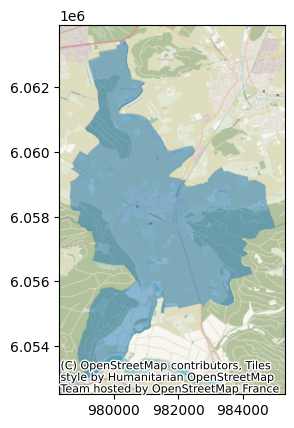

In [3]:
ramsen_grenze = osmnx.geocode_to_gdf("Ramsen, Switzerland")
# Für die Kartenvorschau mit contextily müssen die
# Koordinaten in Spherical Mercator (EPSG 3857) vorliegen: 
ramsen_grenze = ramsen_grenze.to_crs(epsg=3857)
ramsen_grenze_plot = ramsen_grenze.plot(alpha=0.5)
contextily.add_basemap(ramsen_grenze_plot)

Als nächstes werden die **öffentlichen Spielplätze** in Ramsen aus dem OSM-Datensatz bezogen:

In [4]:
spielplaetze_in_ramsen = osmnx.features_from_place(query="Ramsen, Switzerland", tags={"leisure": "playground"})

Die Spielplatz-Standorte aus dem OSM-Datensatz liegen standardmässig im geographischen Koordinatenbezugssystem (KBS) **WGS84** vor. Für die Verwendung der Daten in räumlichen Operationen und in der Kartenvisualisierung müssen diese in ein projeziertes KBS transformiert werden. Im Folgeschritt erfolgt daher eine Transformation der Spielplatz-Koordinaten zu **Spherical Mercator** (EPSG-Code 3857). Anschliessend wird die **Tabelle vereinfacht** (unbenötigte Spalten entfernt) und der **Tabellen-Index neu gesetzt**, damit eine nutzbare Zählung der Zeilen vorliegt:

In [5]:
spielplaetze_in_ramsen = spielplaetze_in_ramsen.to_crs(epsg=3857)
spielplaetze_in_ramsen = spielplaetze_in_ramsen.reset_index()
spielplaetze_in_ramsen = spielplaetze_in_ramsen[["geometry"]]
spielplaetze_in_ramsen

,geometry
0,"POLYGON ((981415.162 6058646.535, 981397.852 6..."
1,"POLYGON ((981031.711 6058291.222, 981015.736 6..."


Den OSM-Daten nach gibt es **zwei öffentliche Spielplätze** in der gesamten Gemeinde Ramsen. Diese sind an den Adressen **Sonnenstrasse 420A** und **Sonnenstrasse 287** zu finden, wie sich der Kartenvorschau der Standorte entnehmen lässt:

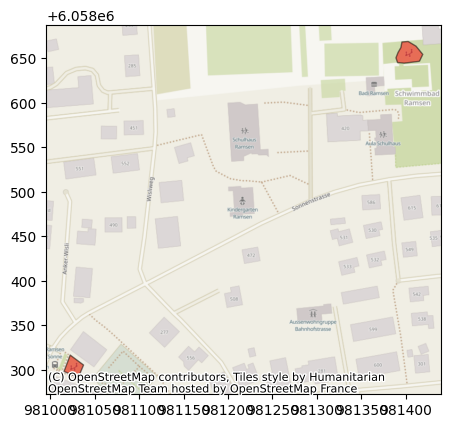

In [6]:
spielplaetze_in_ramsen_plot = spielplaetze_in_ramsen.plot(alpha=0.5, edgecolor='k', color='red')
contextily.add_basemap(spielplaetze_in_ramsen_plot)

Auf Basis von öffentlich verfügbaren Informationen lässt sich nicht feststellen, ob beide Spielplätze **von der Gemeinde betrieben** werden und ob sie überhaupt **öffentlich zugänglich** sind. Es gibt auch keine entsprechende aufklärende Beschilderung vor Ort an diesen beiden Spielplätzen. Daher wird im weiteren einfach davon ausgegangen, dass beide Spielplätze grundsätzlich öffentlich zugänglich sind.

Nun kann mit der Analyse begonnen werden. Es werden zunächst **Puffergebiete** von **200 Metern** um die **beiden Spielplätze** berechnet. Das ergibt die **Luftliniendistanzen** von den Spielplätzen, die als **vereinfachte Gehdistanzen** angenommen werden. Noch besser wäre es hier, die tatsächlichen Gehdistanzen als **Netzwerkanalyse** auf Basis des **Strassennetzes** (z.B. aus OSM) zu ermitteln, dies wäre jedoch eine für diese Untersuchung unnötig aufwändige Prozedur. Im Kontext dieser Untersuchung ist die **Luftliniendistanz als Vereinfachung akzeptabel**.

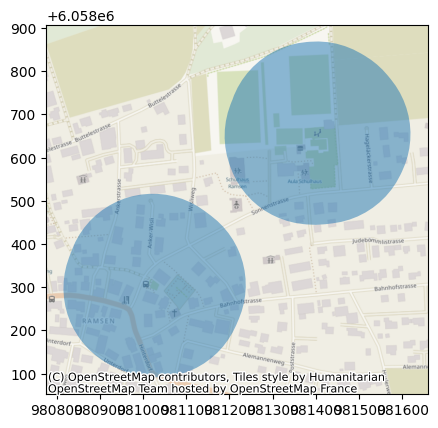

In [7]:
spielplaetze_in_ramsen["buffer"] = spielplaetze_in_ramsen.buffer(200)
spielplaetze_in_ramsen_plot = spielplaetze_in_ramsen["buffer"].plot(alpha=0.5)
contextily.add_basemap(spielplaetze_in_ramsen_plot)

Es folgt eine Darstellung der **200-m-Puffergebiete** um die Spielplätze zusammen mit dem **Gemeindegebiet** als kontextuelle Visualisierung:

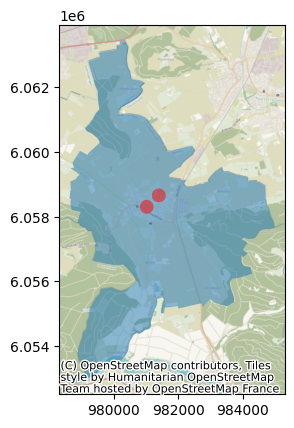

In [8]:
ramsen_grenze_plot = ramsen_grenze.plot(alpha=0.5)
spielplaetze_in_ramsen_plot = spielplaetze_in_ramsen["buffer"].plot(ax = ramsen_grenze_plot, alpha=0.5, color='red')
contextily.add_basemap(spielplaetze_in_ramsen_plot)

In den Folgeschritten werden offizielle Gebäude- und Wohnungsdaten aus dem eidgenössischen _GWR_ des _BfS_ bezogen. Hierzu wird zunächst ein lokaler Ordner für temporäre Daten angelegt:

In [9]:
temp_ordner = "temp"
if not os.path.exists(temp_ordner):
    os.makedirs(temp_ordner)

Das _BfS_ bietet die **GWR-Daten** zum freien öffentlichen Bezug von der sog. **MADD-Plattform** (https://public.madd.bfs.admin.ch). Die Daten werden in einzelnen ZIP-Archiven, getrennt nach Kanton, vorgehalten. Für den Kanton Schaffhausen liegen die GWR-Daten in der Datei `sh.zip`. Als nächstes werden die GWR-Daten in Form der `sh.zip` von der MADD-Plattform online bezogen und lokal im `temp`-Ordner abgelegt:

In [10]:
urlretrieve("https://public.madd.bfs.admin.ch/sh.zip", "temp/sh.zip")

('temp/sh.zip', <http.client.HTTPMessage at 0x294ef1c1220>)

Die **GWR-Daten** liegen nun in Form eines ZIP-Archivs lokal vor. Das ZIP-Archiv muss **lokal extrahiert** werden, um an die **Nutzdaten** zu gelangen:

In [11]:
with zipfile.ZipFile("temp/sh.zip", "r") as sh_archiv:
    sh_archiv.extractall("temp/")

Nach der erfolgreichen Extraktion des Archivs können nun die **Gebäudedaten** aus dem _GWR_ geladen werden. Diese liegen in der Datei `buildings.geojson` vor:

In [12]:
bfs_gebaeude_sh_gdf = geopandas.read_file("temp/buildings.geojson")
bfs_gebaeude_sh_gdf.head()

,egid,buildingStatus,buildingCategory,buildingClass,municipalityNumber,municipalityName,canton,geometry
0,101204811,1004,1060,1271,2901,Gächlingen,SH,POINT (2679110.508 1284656.239)
1,101204819,1004,1060,0,2901,Gächlingen,SH,POINT (2679575.489 1284227.506)
2,101204820,1004,1020,1110,2901,Gächlingen,SH,POINT (2679748.127 1284539.545)
3,101204851,1004,1020,1110,2901,Gächlingen,SH,POINT (2679535.355 1284314.424)
4,101204852,1004,1020,1110,2901,Gächlingen,SH,POINT (2679520.909 1284303.583)


Dies sind **alle Gebäudeobjekte** aus dem **Kanton Schaffhausen**. Um nur die Gebäude aus der **Gemeinde Ramsen** zu erhalten, muss der Datensatz auf den **offiziellen Gemeindeschlüssel** von Ramsen gefiltert werden. Der offizielle statistische Gemeindeschlüssel von Ramsen lautet **2963**:

In [13]:
gebaeude_ramsen_gdf = bfs_gebaeude_sh_gdf[bfs_gebaeude_sh_gdf["municipalityNumber"] == 2963]
gebaeude_ramsen_gdf["egid"].count()

1179

Stand _Herbst 2024_ hat es insgesamt **1'179 Gebäudeobjekte** im Datenbestand des BfS für Ramsen.

In dem Datenbestand befinden sich jedoch nicht nur bestehende Gebäude, sondern z.B. auch abgerisse Bauten. Um nur die **bestehenden Gebäude** zu erhalten, muss auf den entsprechenden **Gebäudestatus gefiltert** werden. Die Gebäudestatus werden im GWR **kodiert** geführt. Die Bedeutung der Codes kann dem öffentlich verfügbaren **Merkmalskatalog des GWR** entnommen werden. Der Statuscode **1004** bedeutet hierbei "bestehendes Gebäude":

In [14]:
gebaeude_ramsen_gdf = gebaeude_ramsen_gdf[gebaeude_ramsen_gdf["buildingStatus"] == 1004]
gebaeude_ramsen_gdf["egid"].count()

1086

Stand _Herbst 2024_ hat es insgesamt **1'086 Gebäude** in Ramsen.

Des Weiteren enthält der Datenbestand nicht nur Wohngebäude, sondern z.B. auch Gebäude, die nur zu gewerblichen Zwecken genutzt werden. Für diese Analyse sind jedoch explizit **nur Wohngebäude** von Interesse. Daher werden im Folgeschritt alle Gebäude **ohne Wohnnutzung** aus den Datensatz **entfernt**. Dies geht durch einen einen Filter auf das **Kategorie**-Attribut der Gebäude. Auch diese Werte sind nach Merkmalskatalog kodiert. Laut Merkmalskatalog hat der Code **1060** der **Kategorie** die Bedeutung "Gebäude ohne Wohnnutzung":

In [15]:
wohngebaeude_ramsen_gdf = gebaeude_ramsen_gdf[gebaeude_ramsen_gdf["buildingCategory"] != 1060]
wohngebaeude_ramsen_gdf["egid"].count()

527

Stand _Herbst 2024_ hat es nach offiziellen Quellen insgesamt **527 Wohngebäude** in der Gemeinde Ramsen.

In der Kartenvorschau lässt sich die **räumliche Verteilung** der Wohngebäude in Ramsen erkennen:

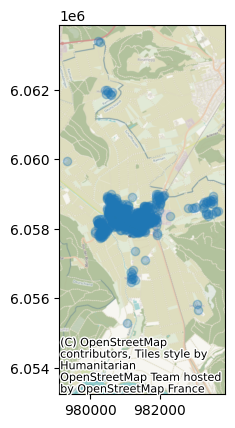

In [16]:
contextily.add_basemap(wohngebaeude_ramsen_gdf.to_crs(epsg=3857).plot(alpha=0.3))

Mit blossem Auge betrachtet lassen sich aus der oberen Kartenvorschau in Ramsen **zwei grössere Wohngebiet-Cluster** identifizieren:
- ein Wohngebiet im **Gemeindezentrum** und
- eines im Osten ("**Wiesholz**").

Die restlichen Wohnüberbauungen sind im Vergleich dazu dünn besiedelt und recht stark gestreut.

In den nächsten Schritten wird die Anzahl der Wohnungen, die innerhalb der Spielplatzpuffer liegen, ermittelt. Dazu werden zunächst die Koordinaten der bereits berechnet **Puffergebiete** in das Schweizer KBS **LV95** transformiert, um entsprechende **räumliche Operationen** in Kombination mit den **GWR-Daten**, die auch in **LV95** vorliegen, durchführen zu können.

In [17]:
spielplaetze_puffer_gdf = geopandas.GeoDataFrame(geometry=spielplaetze_in_ramsen["buffer"], crs=3857)
spielplaetze_puffer_gdf = spielplaetze_puffer_gdf.to_crs(epsg=2056)
spielplaetze_puffer_gdf.head()

,geometry
0,"POLYGON ((2703241.692 1285275.080, 2703244.057..."
1,"POLYGON ((2703253.806 1284924.989, 2703248.229..."


Nun kann ein **räumlicher Verschnitt** (_Spatial Join_) zwischen den **Gebäudepunkten** des **GWR-Datensatzes** und den errechneten **200-m-Puffergebieten der Spielplätze** durchgeführt werden, um die Gebäude zu identifizieren, die **in 200 Meter Entfernung** von den Spielplätzen liegen:

In [18]:
gebauede_spielplaetze_200m = geopandas.sjoin(wohngebaeude_ramsen_gdf, spielplaetze_puffer_gdf, how="inner", predicate="intersects")
gebauede_spielplaetze_200m["egid"].count()

70

Es liegen **70 Geäude** in einem Umkreis von **200 Metern** um öffentliche Spielplätze in Ramsen.

Doch wesentlich **aussagekräftiger** als die **Anzahl der Gebäude** ist für diese Untersuchung die **Anzahl der Wohnungen**, die in den Puffergebieten liegen. Daher werden im Folgenden auch die **Wohnungsdaten** aus dem GWR geladen:

In [19]:
bfs_wohnungen_sh_df = geopandas.read_file("temp/wohnung_logement_abitazione.csv")
bfs_wohnungen_sh_df.head()

,EGID,EWID,EDID,WHGNR,WEINR,WSTWK,WBEZ,WMEHRG,WBAUJ,WABBJ,WSTAT,WAREA,WAZIM,WKCHE,WEXPDAT,geometry
0,470001,1,0,,,3100,,1,1999,,3004,150,7,1,2024-10-13,None
1,470002,1,0,,,3100,,1,1999,,3004,110,3,1,2024-10-13,None
2,470003,1,0,,,3100,,1,1999,,3004,150,5,1,2024-10-13,None
3,470004,1,0,,,3100,,1,1999,,3004,190,4,1,2024-10-13,None
4,470005,1,0,,,3100,,0,1999,,3004,140,4,1,2024-10-13,None


Bei diesem Datensatz handelt es sich um **alle aktuellen Wohnungen** im **Kanton Schaffhausen**. Auch hier sind **nicht nur die bestehenden Wohnungen** enthalten, sodass diese zunächst gefiltert werden müssen. Und auch hier kann über das **Status**-Attribut an den Wohnungen auf die **bestehenden Wohnungen** reduziert werden. Der Statuscode **3004** bedeutet hierbei "Wohnung bestehend":

In [20]:
bfs_wohnungen_sh_df = bfs_wohnungen_sh_df[bfs_wohnungen_sh_df["WSTAT"] == "3004"]
bfs_wohnungen_sh_df["EGID"].count()

45896

Es gibt **45'896 bestehende Wohnungen** im gesamten **Kanton Schaffhausen**.

Als nächstes soll die **Gesamtzahl der Wohnungen** in der Gemeinde Ramsen bestimmt werden. Hierzu können die bereits ermittelten Gebäude aus Ramsen mit den kantonalen Wohnungen per **Eidgenössischer Gebäude-ID** (_EGID_) verschnitten werden. Für so einen **Mengenverschnitt** hat die _EGID_ im Wohnungsdatensatz jedoch den **unpassenden Datentyp** _object_. Der Datentyp muss daher vorgängig in einen **numerischen, ganzzahligen Datentyp** geändert werden:

In [21]:
bfs_wohnungen_sh_df["EGID"] = pandas.to_numeric(bfs_wohnungen_sh_df["EGID"])
bfs_wohnungen_sh_df["EGID"].dtype

dtype('int64')

Nun kann der **Mengenverschnitt** per _EGID_ zwischen dem Gebäude- und dem Wohnungsdatensatz erfolgen, der die **Anzahl der Wohnungen in Ramsen** ergibt:

In [22]:
liste_der_egids = wohngebaeude_ramsen_gdf["egid"].to_list()
wohnungen_ramsen = bfs_wohnungen_sh_df[bfs_wohnungen_sh_df["EGID"].isin(liste_der_egids)]
anz_wohnungen_ramsen = wohnungen_ramsen["EGID"].count()
anz_wohnungen_ramsen

809

Stand _Herbst 2024_ hat es **809 Wohnungen** in ganz Ramsen.

Im Vergleich dazu soll nun nur die **Anzahl der Wohnungen** ermittelt werden, die in einer Entfernung bis zu **200 Meter** Entfernung zu Spielplätzen liegen. Auch dies erfolgt über einen Mengenverschnitt der Wohnungen auf die _EGID_ der Gebäude, die im 200-m-Radius liegen:

In [23]:
liste_der_egids = gebauede_spielplaetze_200m["egid"].to_list()
wohnungen_um_spielplaetze_200m = bfs_wohnungen_sh_df[bfs_wohnungen_sh_df["EGID"].isin(liste_der_egids)]
anz_wohnungen_200m = wohnungen_um_spielplaetze_200m["EGID"].count()
anz_wohnungen_200m

108

Stand _Herbst 2024_ hat es **108 Wohnungen** in **200 Meter** Entfernung um Spielplätze in Ramsen.

Daraus kann nun letztendlich der **prozentuale Anteil** der Wohnungen berechnet werden, die in 200 Meter Entfernung um Spieplätze liegen:

In [24]:
anz_wohnungen_200m /anz_wohnungen_ramsen * 100

13.349814585908529

Stand Herbst 2024 liegen **~ 13 %** der Wohnungen in der Gemeinde Ramsen in einer Entfernung (Luftlinie) von **max. 200 Meter** von einem Spielplatz entfernt.

Im Folgenden wird der obige Analyseprozess **wiederholt** für einen **400-Meter-Radius** um die **beiden Spielplätze**. Dies entspräche den Richtlinien zur **Erreichbarkeit von Spielplätzen**  der **DIN 18034** für **Kinder bis etwa 12 Jahren** (siehe einleitender Text). Für Ramsen sieht dies in der Kartenvoschau folgendermassen aus:

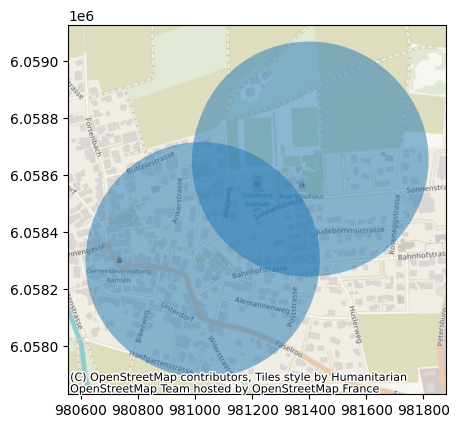

In [25]:
spielplaetze_in_ramsen["buffer"] = spielplaetze_in_ramsen.buffer(400)
spielplaetze_in_ramsen_plot = spielplaetze_in_ramsen["buffer"].plot(alpha=0.5)
contextily.add_basemap(spielplaetze_in_ramsen_plot)

Bei Betrachtung des **400-Meter-Radius** sind die beiden Spielplätze **nicht ideal zueinander** gelegen, da die 400-m-Gebiete **stark überschneiden**. Dies bedeutet im Umkehrschluss, dass das **Erreichbarkeits-Potenzial** der beiden Spielplätze im 400-m-Bereich für andere Haushalte **vergeudet** wird. Für eine Konfiguration im 400-Meter-Bereich, die die Betriebsresourcen der Gemeinde optimiert, wäre daher eine räumliche Umorientierung der Spielpätze sinnvoll.

Im Folgenden wird der **prozentuale Anteil der Wohnungen** im **400-Meter-Radius** bestimmt. Es folgenden daher die gleichen Schritte wie oben bereits für das 200-m-Gebiet durchgeführt. Zunächst werden die **Koordinaten** der Pufferflächen **transformiert**:

In [26]:
spielplaetze_puffer_gdf = geopandas.GeoDataFrame(geometry=spielplaetze_in_ramsen["buffer"], crs=3857)
spielplaetze_puffer_gdf = spielplaetze_puffer_gdf.to_crs(epsg=2056)

Anschliessend erfolgt der **räumliche Verschnitt** mit den Gebäuden in der Gemeinde, um die **Gebäude im Puffergebiet** zu identifizieren:

In [27]:
gebauede_spielplaetze_400m = geopandas.sjoin(wohngebaeude_ramsen_gdf, spielplaetze_puffer_gdf, how="inner", predicate="intersects")

Nun kann die **Anzahl der Wohnungen** in einem Radius von **400 Metern** um die Spielplätze berechnet werden:

In [28]:
liste_der_egids = gebauede_spielplaetze_400m["egid"].to_list()
wohnungen_um_spielplaetze_400m = bfs_wohnungen_sh_df[bfs_wohnungen_sh_df["EGID"].isin(liste_der_egids)]
anz_wohnungen_400m = wohnungen_um_spielplaetze_400m["EGID"].count()

Letztendlich lässt sich daraus der **prozentuale Anteil der Wohnungen** im **400-m-Gebiet** um Spielplätze errechnen:

In [29]:
anz_wohnungen_400m /anz_wohnungen_ramsen * 100

44.9938195302843

Stand _Herbst 2024_ liegen **~ 45&nbsp;%** der Wohnungen in der Gemeinde Ramsen in einer Entfernung (Luftlinie) von **max. 400 Meter** von einem Spielplatz entfernt.

Die Ergebnisse lassen sich folgendermassen zusammenfassen:
- **13&nbsp;%** der Wohnungen in der Gemeinde Ramsen liegen in einer Entfernung (Luftlinie) von **max. 200 Meter** von einem Spielplatz entfernt
- **45&nbsp;%** der Wohnungen in der Gemeinde Ramsen liegen in einer Entfernung (Luftlinie) von **max. 400 Meter** von einem Spielplatz entfernt

Die Analyse der Erreichbarkeit von Spielplätzen in Ramsen zeigt somit, dass
- **ein Grossteil** der Wohnungen **ausserhalb** der empfohlenen maximalen Gehdistanzen von 200 Metern für **Kinder unter 6 Jahren** und
- **mehr als die Hälfte** der Wohnungen **ausserhalb** der für **Kinder bis 12 Jahren** empfohlnen 400-Meter-Entfernung liegt.

Dies bedeutet, dass die Spielplätze in Ramsen **nicht** gut erreichbar und **weit entfernt** von den **Richtlinien der DIN 18034** sind. Diese Ergebnisse **widersprechen** einer Förderung der körperlichen Aktivität und sozialen Interaktion der Kinder in der Gemeinde.

# Datengestützte Entwürfe für eine verbesserte Versorgungssituation

Eine Abdeckung von **100&nbsp;% der Wohnungen** wäre sowohl in der **200-** als auch in der **400-Meter-Entfernung** _unrealistisch_, insbesondere da die Gemeinde Ramsen als ländlicher Ort typischerweise **zersiedelt** ist. Im folgenden soll ermittelt werden, **wie viele zusätzliche Spielplätze** es in Ramsen bräuchte, um eine **Erreichbarkeit** der Spielplätze für zumindest
- **die Hälfte** (50&nbsp;%) aller Wohnungen für **Kinder unter 6 Jahren** und 
- **drei Viertel** (75&nbsp;%) aller Wohnungen für **Kinder bis 12 Jahre** sicherzustellen.

Dies würde folgende Steigerungsraten in der Servicequalität der Gemeinde bzgl. Erreichbarkeit der Spielplätze bedeuten:
- Die Erreichbarkeit für **Kinder unter 6 Jahren** steigt dann von bisher **13&nbsp;%** der Wohnungen auf neu **50&nbsp;%**. Dies wäre eine Steigerung der Service-Qualität um **37&nbsp;%**.
- Die Erreichbarkeit für **Kinder bis 12 Jahre** steigt dann von bisher **45&nbsp;%** der Wohnungen auf neu **75&nbsp;%**. Dies wäre eine Steigerung der Service-Qualität um **30&nbsp;%**.

## Untersuchung der 200-Meter-Erreichbarkeit

In der Geodaten-Datei [`spielplaetze_200m.geojson`](https://github.com/edgarbutwilowski/distanzen_spielplaetze_ramsen_py/blob/main/input/spielplaetze_200m.geojson) im Unterordner `input` befinden sich **Vorschläge** für zusätzliche **Spielplatzstandorte** in Ramsen, die die **200-m-Erreichbarkeit** der Spielplätze auf über **50&nbsp;%** der Wohnungen heben soll. Diese werden im ersten Schritt geladen:

In [30]:
vorschlag_spielplaetze_200m = geopandas.read_file("input/spielplaetze_200m.geojson")
vorschlag_spielplaetze_200m = vorschlag_spielplaetze_200m.to_crs(epsg=3857)

Im Anschluss werden die **200-Meter-Pufferflächen** um die vorgeschlagenen Spielplatzstandorte **berechnet**:

In [31]:
vorschlag_spielplaetze_200m["buffer"] = vorschlag_spielplaetze_200m["geometry"].buffer(200)

Die folgende Kartenvorschau **visualisiert** die **Pufferflächen** der **vorgeschlagenen Spielplatzstandorte** die im Kontext des Gemeindegebiets:

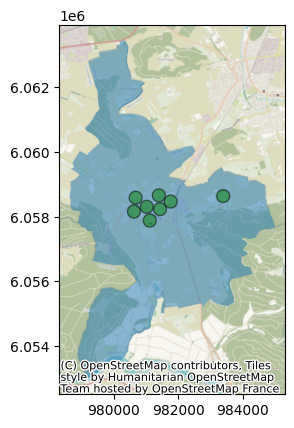

In [32]:
ramsen_grenze = ramsen_grenze.to_crs(epsg=3857)
ramsen_grenze_plot = ramsen_grenze.plot(alpha=0.5)

vorschlag_spielplaetze_200m_plot = vorschlag_spielplaetze_200m["buffer"].plot(ax = ramsen_grenze_plot, alpha=0.5, edgecolor='k', color='green')
contextily.add_basemap(vorschlag_spielplaetze_200m_plot)

Der Vorschlag beinhaltet **sechs neue Spielplätze**, sowie die bereits bestehenden zwei Spielplätze. Damit würden sich für die Gemeinde Ramsen insgesamt **acht Spielplätze** ergeben. Dieser Vorschlag wird im Folgendeden als **Kleinkinder-Aktiv-Variante** bezeichnet, da er sich auf die Erreichbarkeit für **Kinder unter 6 Jahren** bezieht.

Die Standorte der sechs neuen Spielplätze sind dabei nicht bzgl. einer **tatsächlichen Realisierbarkeit** an genau diesen Standorten überprüft. Es wurde also **nicht** geprüft, ob sich an diesem Standort aufgrund der Eigentumsverhältnisse, der bereits bestehenden baulichen Gegebenheiten, der Bodenqualität etc. überhaupt ein Spielplatz errichten lässt. Es geht bei diesem initialen Vorschlag lediglich um eine **räumlich vorteilhafte Abdeckung** in Relation zu der **gesamtheitlichen Wohnüberbauung** in der Gemeinde.

Auf Basis der vorgeschlagenen Standorte stellt sich die Frage, welcher **prozentuale Anteil** der Wohnungen von Ramsen mit diesem Vorschlag für **200-m-Entfernungen** abgedeckt wird. Dies soll in den Folgeschritten ermittelt werden. Zunächst werden wieder die Koordinaten der Pufferflächen **transformiert**:

In [33]:
vorschlag_puffer_200_gdf = geopandas.GeoDataFrame(geometry=vorschlag_spielplaetze_200m["buffer"], crs=3857)
vorschlag_puffer_200_gdf = vorschlag_puffer_200_gdf.to_crs(epsg=2056)

Anschliessend erfolgt der **räumliche Verschnitt** der vorgeschlagenen Spielplatzstandorte mit den Gebäuden in der Gemeinde, um die **Gebäude im Puffergebiet** zu identifizieren:

In [34]:
gebauede_vorschlag_200m = geopandas.sjoin(wohngebaeude_ramsen_gdf, vorschlag_puffer_200_gdf, how="inner", predicate="intersects")

In der Kartenansicht ist dargestellt, welche Wohngebäude mit den **vorgeschlagenen Spielplatzstandorten** in einer **200-Meter-Entfernung** um die Spielplätze liegen würden:

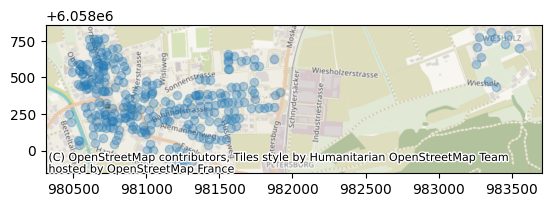

In [35]:
contextily.add_basemap(gebauede_vorschlag_200m.to_crs(epsg=3857).plot(alpha=0.3))

Anschliessend erfolgt die **Zählung der Wohnungen** im **200-m-Radius** der **Vorschlagsspielplätze**:

In [36]:
liste_der_egids = gebauede_vorschlag_200m["egid"].to_list()
wohnungen_vorschlag_200m = bfs_wohnungen_sh_df[bfs_wohnungen_sh_df["EGID"].isin(liste_der_egids)]
anz_wohnungen_vorschlag_200m = wohnungen_vorschlag_200m["EGID"].count()
anz_wohnungen_vorschlag_200m

459

Es liegen **459 Wohnungen** im **200-m-Radius** bei der **Kleinkinder-Aktiv-Variante**.

Final wird wiederum der **prozentuale Anteil** der im **200-m-Radius** liegenden Wohnungen der Vorschlagsvariante **Kleinkinder-Aktiv** errechnet:

In [37]:
prozent_geb_200m_vorschlag = anz_wohnungen_vorschlag_200m / anz_wohnungen_ramsen * 100
prozent_geb_200m_vorschlag

56.736711990111246

Mit der **Kleinkinder-Aktiv-Variante** liegen dann **~57&nbsp;% der Wohnungen** in **200-Meter-Reichweite** zu Spielplätzen. Dies würde also immerhin bei **mehr als der Hälfte der Wohnungen** dafür sorgen, dass die Empfehlungen der DIN 18034 für **Kinder unter 6 Jahren** eingehalten würden (aktuell sind es **13&nbsp;%**).

## Untersuchung der 400-Meter-Erreichbarkeit

Im Folgenden soll dieselbe Untersuchung noch für die **400-Meter-Distanzen**, also nach den Empfehlungen für **Kinder bis 12 Jahre** durchgeführt werden.

In der Geodaten-Datei [`spielplaetze_400m.geojson`](https://github.com/edgarbutwilowski/distanzen_spielplaetze_ramsen_py/blob/main/input/spielplaetze_400m.geojson) im Unterordner `input` befinden sich **Vorschläge** für zusätzliche **Spielplatzstandorte** in Ramsen, die die **400-m-Erreichbarkeit** der Spielplätze auf über **75&nbsp;%** der Wohnungen heben soll. Diese Daten werden im ersten Schritt geladen:

In [38]:
vorschlag_spielplaetze_400m = geopandas.read_file("input/spielplaetze_400m.geojson")
vorschlag_spielplaetze_400m = vorschlag_spielplaetze_400m.to_crs(epsg=3857)

Im Anschluss werden die **400-Meter-Pufferflächen** um die vorgeschlagenen Spielplatzstandorte **berechnet**:

In [39]:
vorschlag_spielplaetze_400m["buffer"] = vorschlag_spielplaetze_400m["geometry"].buffer(400)

Die folgende Kartenvorschau **visualisiert** die **Pufferflächen** der **vorgeschlagenen Spielplatzstandorte** die im Kontext des Gemeindegebiets:

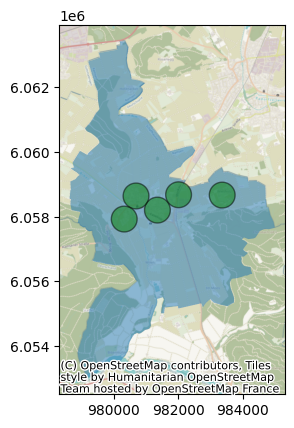

In [40]:
ramsen_grenze_plot = ramsen_grenze.plot(alpha=0.5)
vorschlag_spielplaetze_400m_plot = vorschlag_spielplaetze_400m["buffer"].plot(ax = ramsen_grenze_plot, alpha=0.5, edgecolor='k', color='green')
contextily.add_basemap(vorschlag_spielplaetze_400m_plot)

Der Vorschlag beinhaltet **drei neue Spielplätze**, sowie die bereits bestehenden zwei Spielplätze. Damit würden sich für die Gemeinde Ramsen insgesamt **fünf Spielplätze** ergeben. Dieser Vorschlag wird im Folgendeden als **Kinder-Aktiv-Variante** bezeichnet, da er sich auf die Erreichbarkeit für **Kinder bis 12 Jahre** bezieht. Auch hier sind die Standorte der Spielplätze nicht bzgl. einer **tatsächlichen Realisierbarkeit** an genau diesen Standorten überprüft (siehe Erläuterungen oben).

Auf Basis der vorgeschlagenen Standorte stellt sich die Frage, welcher **prozentuale Anteil** der Wohnungen von Ramsen mit diesem Vorschlag für **400-m-Entfernungen** abgedeckt wird. Dies soll in den Folgeschritten ermittelt werden. Zunächst werden wieder die Koordinaten der Pufferflächen **transformiert**:

In [41]:
vorschlag_puffer_400_gdf = geopandas.GeoDataFrame(geometry=vorschlag_spielplaetze_400m["buffer"], crs=3857)
vorschlag_puffer_400_gdf = vorschlag_puffer_400_gdf.to_crs(epsg=2056)

Anschliessend erfolgt der **räumliche Verschnitt** der vorgeschlagenen Spielplatzstandorte mit den Gebäuden in der Gemeinde, um die **Gebäude im Puffergebiet** zu identifizieren:

In [42]:
gebauede_vorschlag_400m = geopandas.sjoin(wohngebaeude_ramsen_gdf, vorschlag_puffer_400_gdf, how="inner", predicate="intersects")

In der Kartenansicht ist dargestellt, welche Wohngebäude mit den **vorgeschlagenen Spielplatzstandorten** in einer **400-Meter-Entfernung** um die Spielplätze liegen würden:

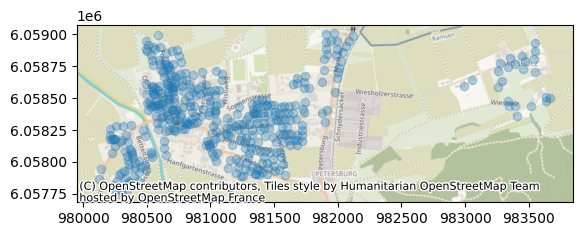

In [43]:
contextily.add_basemap(gebauede_vorschlag_400m.to_crs(epsg=3857).plot(alpha=0.3))

Anschliessend erfolgt die **Zählung der Wohnungen** im **400-m-Radius** der **Vorschlagsspielplätze**:

In [44]:
liste_der_egids = gebauede_vorschlag_400m["egid"].to_list()
wohnungen_vorschlag_400m = bfs_wohnungen_sh_df[bfs_wohnungen_sh_df["EGID"].isin(liste_der_egids)]
anz_wohnungen_vorschlag_400m = wohnungen_vorschlag_400m["EGID"].count()
anz_wohnungen_vorschlag_400m

642

Es liegen **642 Wohnungen** im **200-m-Radius** bei der **Kinder-Aktiv-Variante**.

Final wird wiederum der **prozentuale Anteil** der im **400-m-Radius** liegenden Wohnungen der Vorschlagsvariante **Kinder-Aktiv** errechnet:

In [45]:
prozent_geb_400m_vorschlag = anz_wohnungen_vorschlag_400m / anz_wohnungen_ramsen * 100
prozent_geb_400m_vorschlag

79.35723114956737

Mit der **Kinder-Aktiv-Variante** liegen dann **~79&nbsp;% der Wohnungen** in **400-Meter-Reichweite** zu Spielplätzen. Dies würde also immerhin bei **mehr als drei Viertel der Wohnungen** dafür sorgen, dass die Empfehlungen der DIN 18034 für **Kinder bis 12 Jahre** eingehalten würden (aktuell sind es **45&nbsp;%**).

# Kleines Benchmarking

Zum Schluss folgt noch ein Vergleich bzgl. der Anzahl der Spielplätze mit anderen Gemeinden. Hierbei soll an den besten orientiert und von diesen gelernt werden. **Dänemark** ist laut **Best Countries Ranking 2024**[2] das Land mit der **höchsten Lebensqualität** der Welt. Eine Gemeinde in Dänemark mit ähnlicher Einwohnerzahl wie Ramsen ist **Læsø** (1'789 Einwohner, Stand 2023). Die folgende Anfrage ermittelt die Anzahl der Spielplätze in Læsø aus dem OSM-Datensatz.

In [46]:
spielplaetze_in_laesoe = osmnx.features_from_place(query="Læsø, Denmark", tags={"leisure": "playground"})
# private Spielplätze in Læsø herausfiltern:
spielplaetze_in_laesoe = spielplaetze_in_laesoe[spielplaetze_in_laesoe["access"] != "customers"]
spielplaetze_in_laesoe["geometry"].count()

5

Stand _Herbst 2024_ unterhält **Læsø** insgesamt **fünf öffentlich zugängliche Spielplätze** im Gemeindegebiet.